## Лабораторная работа "Введение в ML"

В этой лабораторной вы:

- познакомитесь с базовыми библиотеками для работы с табличными данными — `numpy` и `pandas`
- поближе посмотрите на простейшие задачи машинного обучения: классификацию и регрессию
- попробуете несколько метрик и поймёте, почему выбор метрики это важно
- обучите несколько простых моделей
- увидите связь между сложностью модели и переобучением
- убедитесь, что без данных всё тлен

Загрузка самых базовых библиотек:

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

from sklearn.model_selection import train_test_split

### [NumPy](https://numpy.org/doc/stable/user/index.html)

С 1995 numeric, с 2006 NumPy — «Numerical Python extensions» или просто «NumPy»

Возможности библиотеки NumPy:
* работать с многомерными массивами (таблицами)
* быстро вычислять математические функций на многомерных массивах

Ядро пакета NumPy — объект [ndarray](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html)

**Важные отличия** между NumPy arrays и Python sequences:
* NumPy array имеет фиксированную длину, которая определяется в момент его создания (в отличие от Python lists, которые могут расти динамически)
* Элементы в NumPy array должны быть одного типа
* Можно выполнять операции непосредственно над NumPy arrays

**Скорость** NumPy достигается с помощью:
* реализации на C
* векторизации и броадкастинга (broadcasting). Например, произведение массивов совместимых форм.

Теперь давайте разберёмся подробнее и сделаем что-нибудь приятное и полезное в `numpy`!

### Индексация

В NumPy работает привычная индексация Python, ура! Включая использование отрицательных индексов и срезов (slices)

<div class="alert alert-info">
<b>Замечание 1:</b> Индексы и срезы в многомерных массивах не нужно разделять квадратными скобками,
т.е. вместо <b>matrix[i][j]</b> нужно использовать <b>matrix[i, j]</b>. Первое тоже работает, но сначала выдаёт строку i, потом элемент j в ней.
</div>

<div class="alert alert-danger">
<b>Замечание 2:</b> Срезы в NumPy создают view, а не копии, как в случае срезов встроенных последовательностей Python (string, tuple and list).
</div>

In [36]:
ones_matrix = np.ones((5, 5))
ones_submatrix_view = ones_matrix[::2,::] # creates a view, not copy
ones_matrix[::2,::2] = np.zeros((3, 3))
ones_submatrix_view

array([[0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0.]])

### Ссылка на Яндекс.Контест

Решения и ответы в задачах, расположенных ниже, загружайте в контест на автоматическую проверку:
https://new.contest.yandex.ru/60376/start


**1.** Реализуйте функцию, принимающую на вход два одномерных массива `first_array` и `second_array` и возвращающую матрицу, в которой первый массив соответствует первому столбцу матрицы, второй — второму.

Вероятно первое, что приходит вам на ум, это конкатенация и транспонирование:

In [37]:
import numpy as np

def construct_matrix(x, y):
    return np.hstack((np.reshape(x, (len(x), 1)), np.reshape(y, (len(y), 1))))



In [38]:
construct_matrix(np.array([1,2, 3, 4]),np.array([5, 6, 7, 8]))

array([[1, 5],
       [2, 6],
       [3, 7],
       [4, 8]])

(в скобках заметим, что конкатенировать можно vertically, horizontally, depth wise методами vstack, hstack, dstack по трём осям (0, 1 и 2, соотвественно), либо в общем случае `np.concatenate` — поиграйтесь ниже с прекрасным примером четырёхмерной точки, чтобы точно всё для себя понять)

In [39]:
a = [[1, 2, 3],]
b = [[4, 5, 6],]
c = np.array([[7, 8],]).T
d = np.vstack((a, b))
np.hstack((d, c,))


array([[1, 2, 3, 7],
       [4, 5, 6, 8]])

In [40]:
p = np.arange(1).reshape([1, 1, 1, 1])
p

array([[[[0]]]])

In [41]:
print("vstack: ", np.vstack((p, p)).shape)
print("hstack: ", np.hstack((p, p)).shape)
print("dstack: ", np.dstack((p, p)).shape)
print("stacked: ", np.dstack((p, p)))

vstack:  (2, 1, 1, 1)
hstack:  (1, 2, 1, 1)
dstack:  (1, 1, 2, 1)
stacked:  [[[[0]
   [0]]]]


In [42]:
np.concatenate((p, p), axis=3)

array([[[[0, 0]]]])

Но, поскольку операция транспонирования [делает массив non-contiguous](https://numpy.org/doc/stable/user/basics.copies.html#other-operations), мы в этой задаче **запретим** ей пользоваться и порекомедуем воспользоваться, например, методом [reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html).

**2.** Реализуйте функцию, принимающую на вход массив целых неотрицательных чисел `nums` и возвращающую самый частый элемент массива.

In [43]:
def most_frequent(nums):
    """
    Find the most frequent value in an array
    :param nums: array of ints
    :return: the most frequent value
    """
    return np.bincount(nums).argmax()
    
most_frequent([1, 2, 2, 2, 3, 1, 1, 1])

np.int64(1)

### Переходим к работе с данными

Прежде всего, загрузим данные и сделаем из них красивые pandas-таблички. Они взяты из параллели RecSys соревнования https://yandex.ru/cup/ml/. Но мы будем иметь дело не со всеми данными, а только с их частью. Данные у нас будут про заведения общественного питания (больше бюрократический терминологии!)

Файлы с данными можно найти [здесь](https://disk.yandex.ru/d/YWvCNRQMb7QSQA).

Задачей будет **предсказание среднего чека** (average_bill) по некоторым другим свойствам заведения.

In [44]:
base = os.path.abspath('.') + '/'

In [45]:
data = pd.read_csv(base + 'organisations.csv')
features = pd.read_csv(base + 'features.csv')
rubrics = pd.read_csv(base + 'rubrics.csv')

В основном мы будем работать с табличкой `data`; остальное вам может пригодиться, если вы захотите знать, какое содержание стоит за кодами признаков.

## Изучение данных

Посмотрите на данные. В этом вам поможет метод ``head`` pandas-таблички.

In [46]:
# <Your code here>
data[['city', 'average_bill', 'rating', 'rubrics_id', 'features_id']].head()

,city,average_bill,rating,rubrics_id,features_id
0,msk,1500.0,4.270968,30776 30774,3501685156 3501779478 20422 3502045016 3502045...
1,msk,500.0,4.375000,30771,1509 1082283206 273469383 10462 11617 35017794...
2,msk,500.0,4.000000,31495,10462 11177 11617 11629 1416 1018 11704 11867 ...
3,msk,500.0,4.538813,30776 30770,3501618484 2020795524 11629 11617 1018 11704 2...
4,msk,500.0,4.409091,31495,11617 10462 11177 1416 11867 3501744275 20282 ...


Полезно посмотреть внимательнее на то, с какими признаками нам предстоит работать.

* **org_id** вам не понадобится;
* **city** - город, в котором находится заведение (``msk`` или ``spb``);
* **average_bill** - средний чек в заведении - он будет нашим таргетом;
* **rating** - рейтинг заведения;
* **rubrics_id** - тип заведения (или несколько типов). Соответствие кодов каким-то человекочитаемым типам живёт в табличке ``rubrics``
* **features_id** - набор неких фичей заведения. Соответствие кодов каким-то человекочитаемым типам живёт в табличке ``features``

Обратите внимание, что **rubrics_id** и **features_id** - это не списки, а разделённые пробелами строки. Когда вам захочется работать с отдельными фичами из мешка фичей для данного заведения, вам придётся всё-таки превратить их в списки (здесь поможет метод `split` для строк).

Чтобы быстро восстанавливать по рубрикам и фичам их нормальные названия, сделайте словари вида ``код_фичи:название_фичи``

In [47]:
# <Your code here>

rubric_dict = {rubrics['rubric_id'][i]:rubrics['rubric_name'][i] for i in range(0, len(rubrics['rubric_id']))}

Посмотрим, какими бывают типы заведений:

In [48]:
rubric_dict

{np.int64(30519): 'Булочная, пекарня',
 np.int64(30770): 'Бар, паб',
 np.int64(30771): 'Быстрое питание',
 np.int64(30774): 'Кафе',
 np.int64(30775): 'Пиццерия',
 np.int64(30776): 'Ресторан',
 np.int64(30777): 'Столовая',
 np.int64(31286): 'Спортбар',
 np.int64(31350): 'Кондитерская',
 np.int64(31375): 'Суши-бар',
 np.int64(31401): 'Кальян-бар',
 np.int64(31495): 'Кофейня',
 np.int64(3108292683): 'Бар безалкогольных напитков',
 np.int64(3501514558): 'Фудкорт',
 np.int64(3501750896): 'Кофе с собой'}

Мы что-то поняли про признаки, которыми нам предстоит пользоваться. Теперь время посмотреть на таргет. Вооружившись функциями ``hist`` и ``scatter`` из библиотеки ``matplotlib``, а также методом ``isna`` для pandas-таблиц разберитесь, какие значения принимают таргеты, есть ли там там выбросы, пропуски или ещё какие-то проблемы.

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    <ol>
      <li>Среди таргетов довольно много пропусков;</li>
      <li>Все таргеты - это числа, кратные 500;</li>
      <li>Есть какие-то адские значения, превышающие 100 000 (видимо, выбросы);</li>
      <li>В целом, число ресторанов с данным средним чеком быстро падает с ростом среднего чека. Для средних чеков, больших 2500, заведений уже совсем мало. Примерно у 2/3 заведений средний чек 500.</li>
    </ol>
</details>

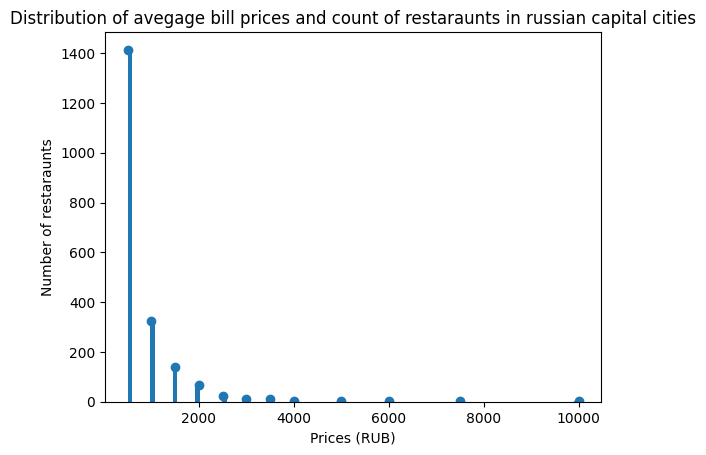

In [49]:
record_count = len(data['average_bill'].dropna())
sample = data.dropna().head(2000)
x = sample['average_bill'].unique()
y = [len(sample['average_bill'][sample['average_bill'] == x[i]]) for i in range(len(x))]
plt.scatter(x, y)
plt.hist(x=x, weights=y, bins=100, align='mid')

plt.title("Distribution of avegage bill prices and count of restaraunts in russian capital cities")
plt.xlabel('Prices (RUB)')
plt.ylabel("Number of restaraunts")
plt.show()


**Базовая очистка данных**

Раз есть треш, давайте чистить данные.

С пропусками можно бороться по-разному (даже и с пропусками в таргете), но пока мы сделаем самую простую вещь: дропнем все заведения, для которых мы не знаем средний чек.

Уберите из них все заведения, у которых средний чек неизвестен или превышает 2500. Пока есть опасение, что их слишком мало, чтобы мы смогли обучить на них что-нибудь.

**3. Введите в Контест количество заведений, которое у вас получилось после очистки**.

Дальше мы будем работать с очищенными данными.

In [50]:
clean_data = data[data['average_bill'] <= 2500]
clean_data.count()

org_id          32136
city            32136
average_bill    32136
rating          27818
rubrics_id      32136
features_id     32136
dtype: int64

**4. Посчитайте и введите в Контест разность между средними арифметическими average_bill в кафе Москвы и Санкт-Петербурга. Округлите ответ до целого.**

&nbsp;

<details>
  <summary>Небольшая подсказка</summary>
  Примените часто используемый метод groupby.
</details>

In [51]:
clean_data[clean_data['city'] == 'msk']['average_bill'].mean() - clean_data[clean_data['city'] == 'spb']['average_bill'].mean()

np.float64(116.43756751957676)

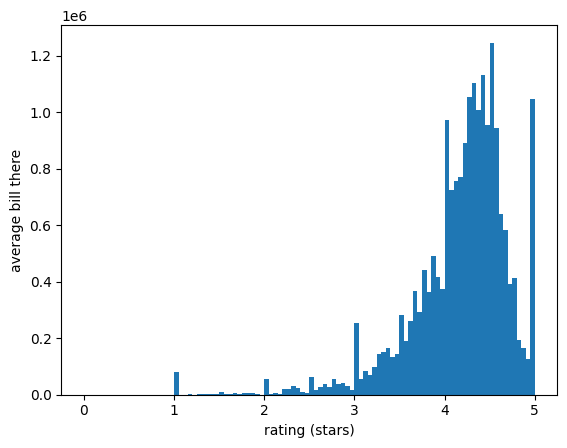

In [52]:
# <Your code here>
clean_data[['average_bill', 'city', 'rating']].groupby(by=['city']).mean()
clean_data[['rating', 'average_bill']].groupby(by=['average_bill']).mean()
x = clean_data['rating']
y = clean_data['average_bill']
plt.hist(x=x, weights=y, bins=100)

plt.xlabel("rating (stars)")
plt.ylabel('average bill there')
plt.show()



Давайте ещё немного поизучаем данные. Ответьте на вопросы:

1. Есть ли разница между средними чеками в Москве и Санкт-Петербурге?
2. Коррелирует ли средний чек с рейтингом?
3. Есть ли разница в среднем чеке между ресторанами и пабами (см. соответствующие типы из ``rubrics``)?

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    <ol>
      <li>В целом, да. Вы могли бы сравнить средние (в Москве больше) или медианы (они равны, потому что уж больно много где средний чек 500). Этого, конечно, мало для того, чтобы сделать вывод. Нужно проверять какие-то статические критерии, которые изучаются в курсе по статистике. Не будем останавливаться на этом подробно. Поскольку данные совсем не нормальные, никакой t-тест не сработает; мы бы предложили использовать критерий Манна-Уитни (см. википедию и функцию mannwhitneyu из библиотеки scipy.stats).</li>
      <li>Какая-то корреляция между ними есть но уж больно неубедительная (рекомендуем построим на одном графике boxplot рейтинга по каждому значению среднего чека для визуализации). Конечно, дна становится меньше с ростом среднего чека, но, видимо, в предсказании это особо не используешь;</li>
      <li>Несомненно, в ресторанах средний чек выше. Это и невооружённым глазом видно, и с помощью критерия Манна-Уитни можно проверить.</li>
    </ol>
</details>

## Формулируем задачу

Прежде, чем решать задачу, её надо сформулировать.

**Вопрос первый**: это классификация или регрессия? Подумайте над этим.

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    Ответ не столь однозначен, как хотелось бы. С одной стороны, таргет принимает всего четыре значения, и потому это может быть классификацией с 4 классами. С другой стороны, таргеты - это не абстрактные "треугольник", "круг", "квадрат", а вещественные числа, и когда мы вместо 500 предсказываем 2500, это явно хуже, чем вместо 1500 предсказать 2000. В целом, задачу можно решать и так, и так; мы будем смотреть на метрики обеих задач.
</details>

**Вопрос второй**: какие метрики мы будем использовать для оценки качества решения? Какие метрики вы предложили бы для этой задачи как для задачи классификации? А для этой задачи, как для задачи регрессии?

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    
    Начнём с классификации. Метрика accuracy не очень хороша из-за несбалансированности классов. Действительно, классификатор, который всегда говорит 500, будет иметь accuracy примерно 0.66, хотя это никак не отражает практическую ценность модели. Как мы увидим, самая большая проблема будет заключаться в том, чтобы научиться выделять заведения с большими чеками, а их меньше всего и в accuracy они вносят самый маленький вклад. Есть разные способы с этим бороться, один -- использовать sklearn.metrics.balanced_accuracy_score. Его идея, грубо говоря, в том, чтобы по каждому классу найти, какая доля объектов этого класса правильно классифицирована, а потом эти доли усреднить. Тогда у бессмысленного классификатора, который всем ставит 500, будет скор 1/5 (ведь классов 5), а чтобы получить прежние 2/3, нужно будет научиться в каждом классе правильно ставить хотя бы 2/3 меток.    
    
    Теперь что касается регрессии. Основых метрики две - MSE и MAE. Из первой стоит извлекать корень, чтобы получать интерпретируемые человеком значения, а вторая менее агрессивна к выбросам (впрочем, выбросов тут уже нет, мы их все выкинули). Без дополнительной информации не очень понятно, какую выбирать, можно брать любую. А выбирать надо: ведь даже банальные модели "предсказывай всегда среднее" и "предсказывай всегда медиану" будут по-разному ранжироваться этими метриками.
    
</details>

**Вопрос третий**: а не взять ли нам какую-нибудь более экзотическую метрику? Например, MAPE (определение в учебнике в главе про оценку качества моделей). А как вам такое соображение: допустим, заказчик говорит, что пользователи будут расстраиваться, только если мы завысили средний чек - так давайте поправим MSE или MAE, обнуляя те слагаемые, для которых предсказанный таргет меньше истинного. Вот это хорошая метрика или нет?

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    
    Что касается MAPE, у нас нет тех проблем, с которой она борется. Вот если бы у нас были средние чеки от 500 до миллиона, мы бы столкнулись с ситуацией, что большие ошибки для больших чеков доминировали бы в сумме для MSE и MAE (500 вместо 1000 меркнет по сравнению с 500к вместо миллиона). Говоря поэтически, мы бы оптимизировали модель для миллионеров, забыв про простых трудяг. И было бы логично перейти от парадигмы "ошибаемся на 500 рублей" к парадигме "ошибаемся на 50%". Но у нас все таргеты примерно одного порядка, MAPE нам особо ни к чему.
    
    Вторая метрика коварна тем, что её можно "накрутить" безо всякой пользы для дела. А именно, модель, которая всегда предсказывает средний чек в миллион, была бы идеальна. Но все бы расстраивались и не ходили есть. Другое дело, что можно ввести разные веса для ошибок в большую и в меньшую сторону, но опять же - пока нет показаний к тому, что это нужно.
    
</details>

## Применяем ML

Теперь время разбить данные на обучающую и тестовую выборку. Делается это с помощью функции ``train_test_split`` из пакета ``sklearn``. При этом очень важно сделать две вещи:

* Зафиксировать ``random_state=42`` (да, именно этот, а то ваши модели могут не зайти в Контест), чтобы всё, что мы делаем, было воспроизводимо (иначе от перезапуска к перезапуску числа могут меняться, и мы не будем понимать, из-за чего это происходит).
* Сделать стратификацию по таргету. В противном случае у нас в трейне и тесте могут оказаться разные пропорции классов (обычно особенно страдают мало представленные классы), что неутешительно скажется на результате.

**Обратите внимание**, что если вы побьёте выборку на train и test по-другому, ваши результаты могут не зайти в контест.

In [53]:
clean_data_train, clean_data_test = train_test_split(
    clean_data, stratify=clean_data['average_bill'], test_size=0.33, random_state=42)

Теперь нам нужен **бейзлайн** - очень простая модель, с которой мы в дальнейшем будем сравниваться.

Поскольку мы ещё не знаем никаких умных классов моделей, все модели мы будем писать руками. А именно, мы напишем две простых модели на основе ``sklearn.baseRegressorMixin`` и ``sklearn.base.ClassifierMixin`` (посмотрите примеры в документации sklearn и сделайте так же):

* Модель для задачи регрессии, которая для всех заведений предсказывает одно число — среднее значение среднего чека;
* Модель для задачи классификации, которая для всех заведений предсказывает один класс — самый частый класс (ироничным образом он в данном случае совпадает с медианой).

**Важно!** Мы будем много раз повторять вам мантру о том, что **информация из тестовой выборки не должна протекать в процесс обучения**. Так вот, и среднее, и самый частый класс вы должны считать именно на обучающей выборке!

**5 и 6. Напишите эти две модели и сдайте в Контест**. В процессе проверки модели будут и обучаться, и предсказывать.

Заметим, что для этих моделей нам вообще не нужны какие-то "фичи"; мы работаем только с таргетом.

У каждой модели есть (как минимум) два метода: `fit` (обучает модель по фичам `X` и таргету `y`) `predict` (предсказывает по фичам `X`)

In [54]:
from scipy.stats import mode

from sklearn.base import RegressorMixin

class MeanRegressor(RegressorMixin):
    # Predicts the mean of y_train
    def fit(self, X=None, y=None):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Training data features
        y : array like, shape = (_samples,)
        Training data targets
        '''
        self.mean_value = y.mean()

    def predict(self, X=None):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Data to predict
        '''
        return [self.mean_value for i in range(len(X))]

from sklearn.base import ClassifierMixin

class MostFrequentClassifier(ClassifierMixin):
    # Predicts the rounded (just in case) median of y_train
    def fit(self, X=None, y=None):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Training data features
        y : array like, shape = (_samples,)
        Training data targets
        '''
        self.most_frequent_value = mode(y).mode

    def predict(self, X=None):
        '''
        Parameters
        ----------
        X : array like, shape = (n_samples, n_features)
        Data to predict
        '''
        return [self.most_frequent_value for i in range(len(X))]


Обучим наши модели

In [55]:
reg = MeanRegressor()
reg.fit(y=clean_data_train['average_bill'])

clf = MostFrequentClassifier()
clf.fit(y=clean_data_train['average_bill'])


In [56]:
from sklearn.metrics import mean_squared_error, balanced_accuracy_score
mse_reg = np.sqrt(mean_squared_error(clean_data_test['average_bill'], reg.predict(clean_data_test['average_bill'])))
bas_clf = np.sqrt(balanced_accuracy_score(clean_data_test['average_bill'], clf.predict(clean_data_test)))
mse_clf = np.sqrt(mean_squared_error(clean_data_test['average_bill'], clf.predict(clean_data_test)))

print(f"Regressor: {mse_reg}, Classifier: {bas_clf}, Classifier (MSE): {mse_clf}")

Regressor: 448.7143889551622, Classifier: 0.4472135954999579, Classifier (MSE): 514.7517402382093


Обучите модели и оцените их качество на тестовой выборке. В качестве метрик возьмём RMSE (``np.sqrt`` от ``sklearn.metrics.mean_squared_error``) и ``sklearn.metrics.balanced_accuracy_score``.

Для регрессионной модели имеет смысл считать только RMSE (значения будут не кратны 500, точно мы угадывать не будем никогда), а вот для классификационной можно найти обе метрики. Сделайте это. Какая модель оказалась лучше по RMSE?

<details>
  <summary>Когда будете готовы, кликните сюда</summary>
    
  Казалось бы, регрессор никогда не угадывает, но он в каком-то смысле лучше классификатора - справедливо ли это? Возможно. Несуществующий пользователь модели вряд ли будет задавать вопросы "почему средний чек не кратен 500?" Ну, выдали около 800 - ок, понятно.
    
</details>

## Усложнение модели

Бейзлайны будут нашей отправной точкой. Строя дальнейшие модели, мы будем спрашивать себя: получилось ли лучше бейзлайна? Если нет или если не особо, то в чём смысл усложнения?

Начнём с использования фичи ``city``. Мы уже видели, что в разных городах и средние чеки разные. Легко проверить, что *медиана* средних чеков всё же одна и та же и в Москве, и в Санкт-Петербурге (ох уж этот вездесущий средний чек 500!), поэтому с классификатором мы ничего не сделаем. Но вот регрессор можно попробовать починить.

**7. Напишите регрессор, для каждого заведения предсказывающий среднее значение в том же городе (на обучающей выборке, конечно) и сдайте его в Контест**. Вам может помочь то, что булевы `pandas` и `numpy` столбцы можно умножать на численные — в такой ситуации False работает, как ноль, а True как единица.

In [57]:
from sklearn.base import RegressorMixin

class CityMeanRegressor(RegressorMixin):
    def fit(self, X=None, y=None):
        self.prediction_msk = np.float64(792.6111908177905)
        self.prediction_spb = np.float64(677.7104465814781)
    def predict(self, X: pd.DataFrame = None):
        return [(self.prediction_spb if x == 'spb' else self.prediction_msk) for x in X['city']]

creg = CityMeanRegressor()
creg.fit(X=clean_data_train, y=clean_data_train['average_bill'])
print(creg.predict(clean_data_test))
np.sqrt(mean_squared_error(clean_data_test['average_bill'], creg.predict(clean_data_test)))

[np.float64(677.7104465814781), np.float64(792.6111908177905), np.float64(792.6111908177905), np.float64(792.6111908177905), np.float64(677.7104465814781), np.float64(792.6111908177905), np.float64(792.6111908177905), np.float64(677.7104465814781), np.float64(677.7104465814781), np.float64(677.7104465814781), np.float64(792.6111908177905), np.float64(677.7104465814781), np.float64(677.7104465814781), np.float64(677.7104465814781), np.float64(792.6111908177905), np.float64(792.6111908177905), np.float64(792.6111908177905), np.float64(677.7104465814781), np.float64(792.6111908177905), np.float64(792.6111908177905), np.float64(792.6111908177905), np.float64(677.7104465814781), np.float64(792.6111908177905), np.float64(677.7104465814781), np.float64(792.6111908177905), np.float64(677.7104465814781), np.float64(677.7104465814781), np.float64(792.6111908177905), np.float64(792.6111908177905), np.float64(792.6111908177905), np.float64(792.6111908177905), np.float64(792.6111908177905), np.floa

np.float64(445.1063281403263)

Обучите регрессор и сравните его по метрике RMSE с бейзлайнами. Получилось ли улучшить метрику?

Лучше стало, но, правда, не очень сильно. В этот момент очень важно не просто радовать руководителя приростом в третьем знаке, но и думать о том, что происходит.

Средний средний чек по Москве равен 793, в Санкт-Петербурге - 676, а в целом - 752 рубля. MSE, увы, не поможет вам ответить на вопрос, стало ли лучше пользователю, если вы ему вместо 752 рублей назвали 793. Здесь вскрывается весьма существенный порок MSE в этой задаче. Дело в том, что наш изначальный таргет делит заведения на некоторые "ценовые категории", и различие в средних чеках 500 и 1000 в самом деле существенно. Наверное, мы хотели бы как раз правильно предсказывать ценовые категории. Но MSE не очень помогает нам об этом судить. Дальше мы ещё подумаем, как это исправить.

В любом случае, несмотря на улучшение метрики, мы пока не можем судить, стало ли по жизни лучше от усложнения модели.

Поручинившись немного, возьмём на вооружение другую идею. Давайте использовать типы заведений!

Но с типами есть некоторая проблема: в столбце ``rubrics_id`` не всегда один идентификатор, часто их несколько, и всего комбинаций довольно много. Чтобы не возиться с малочисленными типами, давайте сольём их в один безликий ``other``.

Итак, добавьте в обучающие и тестовые данные столбец ``modified_rubrics``, в котором будет то же, что и в ``rubrics_id``, если соответствующая комбинация рубрик содержит хотя бы 100 заведений из обучающей (!) выборки, и строка ``other`` в противном случае.

Здесь вам поможет контейнер ``Counter`` из библиотеки ``collections``.

In [58]:
frequency = {str(x): len(clean_data_train[clean_data_train['rubrics_id'] == str(x)]) for x in clean_data_test['rubrics_id']}
modified_rubrics_train = pd.Series(data=['other' if (str(r) in frequency.keys()) and (frequency[str(r)] < 100) else str(r) for r in clean_data_train['rubrics_id']], name='modified_rubrics', dtype=str, index=clean_data_train.index)
modified_rubrics_test = pd.Series(data=['other' if (str(r) in frequency.keys()) and (frequency[str(r)] < 100) else str(r) for r in clean_data_test['rubrics_id']], name='modified_rubrics', dtype=str, index=clean_data_test.index)

In [59]:
clean_data_train['modified_rubrics'] = modified_rubrics_train
clean_data_test['modified_rubrics'] = modified_rubrics_test
clean_data_test

,org_id,city,average_bill,rating,rubrics_id,features_id,modified_rubrics
65841,14385912302763770021,spb,1000.0,4.748444,30776 30770 31401,11177 3501618484 10462 3501481355 1509 1416 20...,other
48882,16695436192794975203,msk,500.0,3.793758,30771,3501744275 273469383 3501513153 11617 10462 11...,30771
33711,11841431940065207518,msk,500.0,3.606557,30771 30777,3501773763 3501744275 3501773764 3501618484 15...,other
33544,16028521499441205186,msk,2000.0,4.683841,30776,3501618484 20422 1082283206 11704 11629 21247 ...,30776
35293,12477116204055673498,spb,500.0,4.165394,30776 31401 30770,1524 246 11704 1018 3501618484 2020795524 2124...,other
...,...,...,...,...,...,...,...
55337,9041226080397910513,msk,2500.0,4.408108,30776,11629 11704 10462 11617 3501744275 20424 35017...,30776
64048,14998683880343589209,msk,1000.0,3.555556,30776,273469383 20424 20422 246 1416 11867 11629 104...,30776
22010,1621254442333414922,msk,2000.0,4.402516,30776,273469383 21247 11867 1082283206 20422 246 101...,30776
40089,5620614742257813954,msk,500.0,NaN,30771,11704 1018 273469383 10462 20422,30771


Теперь настало время написать могучий классификатор, который по заведению предсказывает медиану средних чеков среди тех в обучающей выборке, у которых с ним одинаковые `modified_rubrics` и город (вы спросите, почему медиану, а не самый частый -- спишем это на вдохновение; самый частый тоже можно брать - но медиана работает лучше).

**8. Напишите классификатор и сдайте в Контест**.

In [63]:
from sklearn.base import ClassifierMixin

class RubricCityMedianClassifier(ClassifierMixin):
    def fit(self, X:pd.DataFrame=None, y=None):
        self.grouped = X.groupby(by=['modified_rubrics', 'city'])
        self.rubrics_mapping = self.grouped['average_bill'].median()
        self.rubrics_mapping['other']
        
    def predict(self, X=None):
        return [
            self.rubrics_mapping[rubric[1]][city[1]]
                for rubric, city in zip(X['modified_rubrics'].items(), X['city'].items()) 
        ]

rc = RubricCityMedianClassifier()
rc.fit(clean_data_train[['average_bill', 'rubrics_id', 'modified_rubrics', 'city']], clean_data_train['average_bill'])  
rc_pred = rc.predict(clean_data_test)  
mse_rcm = np.sqrt(mean_squared_error(clean_data_test['average_bill'], rc.predict(clean_data_test)))
mse_rca = np.sqrt(balanced_accuracy_score(clean_data_test['average_bill'], rc_pred))

mse_rcm, mse_rca 

(np.float64(393.96675836287915), np.float64(0.5527432662021822))

Сравните обученный классификатор по метрикам RMSE и balanced_accuracy_score с нашими бейзлайнами. Получилось ли улучшить?

Обратите внимание что рост accuracy по сравнению с бейзлайном при этом на порядок меньше:

accuracy_score

Predict most frequent:  0.6947666195190948

Predict by rubric and city:  0.7095709570957096

Для диагностики напечатайте для каждого класса тестовой выборки, сколько в нём объектов и скольким из них наш классификатор приписал правильный класс. Что вы видите?

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
    
  Вы, вероятно, видите то, что мы стали однозначно лучше по сравнению с бейзлайном детектировать средний чек 1000 и 1500 (хотя всё равно не очень хорошо + ценой ухудшения качества на среднем чеке 500), а вот чеки 2000 и 2500 нам ну никак не даются.
    
</details>

In [66]:
clean_data_test.groupby(by='average_bill').count()

,org_id,city,rating,rubrics_id,features_id,modified_rubrics
average_bill,,,,,,
500.0,7368,7368,6496,7368,7368,7368
1000.0,1809,1809,1500,1809,1809,1809
1500.0,890,890,725,890,890,890
2000.0,391,391,309,391,391,391
2500.0,147,147,115,147,147,147


In [125]:
correct_predictions = {float(x):0 for x in sorted(clean_data_test['average_bill'].unique())}
for i in range(len(clean_data_test['average_bill'])):
    if clean_data_test['average_bill'].iloc[i] == rc_pred[i]:
        correct_predictions[rc_pred[i]] += 1

classes_count = clean_data_test.groupby(by='average_bill').count()['org_id']

print(correct_predictions, classes_count, sep='\n')

{500.0: 6608, 1000.0: 700, 1500.0: 217, 2000.0: 0, 2500.0: 0}
average_bill
500.0     7368
1000.0    1809
1500.0     890
2000.0     391
2500.0     147
Name: org_id, dtype: int64


In [127]:
# Теперь можно посчитать полноту в каждом из классов
classes_recall = { i: (correct_predictions[i]) / classes_count[i] for i in correct_predictions.keys()}
classes_recall

{500.0: np.float64(0.8968512486427795),
 1000.0: np.float64(0.3869541182974019),
 1500.0: np.float64(0.24382022471910111),
 2000.0: np.float64(0.0),
 2500.0: np.float64(0.0)}

TypeError: unsupported operand type(s) for /: 'dict_values' and 'int'

**Кстати**. А вы понимаете, почему приведённый выше пайплайн классификации был не очень удачным с точки зрения архитектуры? Почему его было бы правильнее воплотить по-другому?

&nbsp;

<details>
  <summary>Когда будете готовы, кликните сюда, чтобы посмотреть ответ</summary>
Собственно говоря, и не было никакого пайплайна. К счастью, у нас была одна обучающая выборка, мы на ней посчитали список рубрик для modified_rubrics и радовались жизни. Но если бы нам надо было переобучать всё на новых данных, пришлось бы помнить, что их надо везде пересчитать (ведь у нас могли появиться новые рубрики с хотя бы 100 представителями). А уж никакую кросс-валидацию (кто знает - тот поймёт) с нашим подходом к делу и вовсе бы не получилось сделать без боли.
    
Поэтому в следующей лабораторной вы научитесь делать честные пайплайны, в которых преобразование данных, генерация фичей и обучение классификатора будут объединены в один понятный процесс, происходящий на этапе fit.
</details>

## Слишком простые и слишком сложные модели

Бейзлайны у нас слишком просты и потому не очень полезны в жизни. Но если сложность модели растёт бесконтрольно, то тоже получается плохо.

Давайте рассмотрим конкретный пример. Создадим классификатор, использующий одновременно `rubrics_id` и `features_id`.

Сделайте следующее:

- для каждого объекта обучающей выборки сконкатенируйте строку `rubrics_id` с разделителем (например, буквой 'q') и содержимым `features_id`. Полученный столбец озаглавьте `modified_features`. Это не самый клёвый способ заиспользовать все фичи, но сейчас пока сойдёт. Причём на сей раз не будем выкидывать мало представленные значения (вся информация важна, не так ли?).
- при этом для тестовой выборке заменяйте на строку `other` все конкатенации, которые не встретились в обучающей выборке.

То есть элементы в этом столбце будут иметь вид `other` или `30776 30774 q 3502045032 11741 3502045016 1046...`.

Теперь обучите классификатор, который для заведения предсказывает медиану среднего чека по всем объектам тестовой выборки с таким же, как у него, значением `modified_features`, а если такого в обучающей выборке нет, то глобальную медиану среднего чека по всей обучающей выборке.

**9. Загрузите в Контест предсказания этого классификатора на тестовой выборке**

Мы ждём файла **.csv**, у которого в каждой строке будет только одно число - предсказание классификатора.

Возможно, вам будет полезна библиотека ``tqdm``, позволяющая отслеживать в реальном времени, сколько времени уже крутится цикл и сколько итераций ещё осталось. Впрочем, если вы всё написали нормально, то должно работать не очень долго.

Модель, очевидно, очень сложная. Число параметров (различных категорий) в ней сопоставимо с числом объектов в обучающей выборке. А получилось ли хорошо?

Давайте посчитаем RMSE и balanced_accuracy_score на обучающей и на тестовой выборках.

**10. Введите их в Контест**

Налицо переобучение: на трейне метрики отличные, на тесте - вообще никакие

В общем, не гонитесь за чрезмерной сложностью модели..

## ML без данных что компутер без электричества

Возможно, вы смотрите на полученные выше результаты и думаете: вот если бы мы не какие-то убогие медианы предсказывали, а гоняли бы нейросети, то тут-то бы всё и получилось!

Но, увы, совсем даже не всегда от счастья нас отделяет выбор хорошей модели (и стратегии обучения). Если данные не очень, то даже самая крутая модель не сработает. В этой ситуации нужно либо добывать новые фичи каким-то образом, либо собирать новые данные (увеличивать датасет), либо просто бросать задачу.

Давайте посмотрим, что выжмет из наших данных одна из самых мощных моделей для табличных данных - градиентный бустинг на решающих деревьях в исполнении [CatBoost](https://catboost.ai/).

Но прежде, чем сделать fit, нам надо облагородить данные. Несмотря на то, что CatBoost отлично работает с категориальными фичами, мешок признаков из `rubrics_id` или `features_id` может ему оказаться не по зубам. Поэтому мы соберём датасет в пристойную матрицу, создав для каждого типа рубрик и фичей отдельный столбец и записав там единицы для тех объектов, у которых эта рубрика или фича имеет место.

В матрице почти все элементы будут нулями. Такие матрицы считаются **разреженными** и их можно хранить гораздо эффективней, чем просто таблицей. Этим и займёмся)

Есть несколько форматов хранения разреженных матриц (многие из них реализованы в [пакете sparse библиотеки scipy](https://docs.scipy.org/doc/scipy/reference/sparse.html)), и каждый пригоден для чего-то своего.

Создавать разреженную матрицу лучше в [формате COO](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_array.html#scipy.sparse.coo_array). Он предполагает, что разреженная матрица задаётся в виде трёх списков: `row`, `col`, `data`, причём каждая тройка `(row[i], col[i], data[i])` кодирует элемент со значением `data[i]`, стоящий на позиции `(row[i], col[i])`. Считается, что на позициях `(row, col)`, которые ни разу не встретились, стоят нули.

Нетрудно видеть, что заполнять такую матрицу - одно удовольствие, и особенно этому помогает тот факт, что **пара `(row, col)` может встретиться несколько раз** (тогда в итоговой матрице на соответствующей позиции стоит сумма соответствующих `data[i]`). Но, с другой стороны, почти ничего другого с такой матрицей не сделаешь: произвольного доступа к элементам она не предоставляет, умножить её тоже особо ничего не умножишь. Поэтому для дальнейшего использования созданную таким образом матрицу преобразуют в один из более удобных форматов, например, [CSR (compressed sparse row)](https://scipy-lectures.org/advanced/scipy_sparse/csr_matrix.html). Он, к примеру, хорошо подходит для умножения на вектор (потому что матрица хранится по строкам). Не будем разбирать его подробно, но можете почитать по ссылке, если интересно.

Вам нужно будет превратить обучающие и тестовые данные в разреженные матрицы `sparse_data_train` и `sparse_data_test` соответственно, таким образом, что:

- столбец `city` превратится в столбец из единиц и нулей (например, 1 - Москва, 0 - Питер);
- столбец `rating` перекочует в разреженные матрицы без изменений;
- каждый типы рубрик и каждая фича превратятся в отдельный 0-1-принак;

В тестовой выборке будут фичи, которых в обучающей выборке не было. С ними можно по-разному работать, но давайте создадим дополнительную фантомную фичу `feature_other`, в которой будет то, сколько неизвестных по обучающей выборке фичей есть у данного объекта.

In [67]:
# <Your code here>

Данные готовы, и теперь можно запустить катбуст

In [68]:
from catboost import CatBoostClassifier

ModuleNotFoundError: No module named 'catboost'

In [ ]:
# <USE IT!>
clf = CatBoostClassifier()
clf.fit(sparse_data_train, clean_data_train['average_bill'])

**11. Пришлите в Контест balanced_accuracy_score на тестовой выборке, округлённый до двух знаков после запятой**. Стало ли сильно лучше от того, что мы воспользовались таким крутым классификатором?